# Initializations

In [1]:
##### IMPORTS #####
import os, shutil, importlib
import utils; importlib.reload(utils)

# os.environ["CUDA_VISIBLE_DEVICES"]=''

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras

from glob import glob

from PIL import Image
from os.path import join as jp

from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.regularizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.utils import layer_utils

from scipy import ndimage

from sklearn import metrics
from sklearn.cross_validation import train_test_split

from IPython.display import FileLink

%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using TensorFlow backend.
/home/riley/anaconda3/envs/default/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Define Paths

In [2]:
# path = '../data/movielens/'
path = '../data/movielens/sample/'
path_model = path + 'models/'
path_checkpoint = path_model + 'checkpoints/'

In [3]:
batch_size = 32

# Setup Data

##### Load movie and ratings data

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
# ratings.head()

In [5]:
movies = pd.read_csv(path+'movies.csv').set_index('movieId')
# movies.head()

In [6]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
print("Unique movies: %s" % n_movies)
print("Unique users: %s" % n_users)

Unique movies: 9066
Unique users: 671


Update userIds and movieIds so they are continuous integers

In [7]:
userid2idx = {u: i for i, u in enumerate(ratings.userId.unique())}
movieid2idx = {m: i for i, m in enumerate(ratings.movieId.unique())}

In [8]:
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])

##### Define embedding params

In [9]:
n_factors = 50

In [10]:
np.random.seed = 42
seed = np.random.seed

##### Split Data

In [11]:
train, valid = train_test_split(ratings, test_size=0.2)

# CF

## Create Embeddings

In [12]:
def embedding_input(n_in, n_out, reg, name):
    i = Input(shape=(1, ), dtype='int64', name=name)
    return i, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(i)

In [13]:
in_user, emb_u = embedding_input(n_users, n_factors, 1e-4, 'user_in')
in_movie, emb_m = embedding_input(n_movies, n_factors, 1e-4, 'movie_in')

## Dot Model

In [146]:
x = merge([emb_u, emb_m], mode='dot')
x = Flatten()(x)

In [147]:
model = Model(input=[in_user, in_movie], output=x, name='model_dot')
model.compile(Adam(lr=0.01), loss='mse')

In [148]:
model.fit([train.userId.values, train.movieId.values], train.rating.values, batch_size=batch_size, nb_epoch=1,
          validation_data=([valid.userId.values, valid.movieId.values], valid.rating.values))

Train on 80003 samples, validate on 20001 samples
Epoch 1/1
80003/80003 [==============================] - 17s - loss: 5.1839 - val_loss: 3.9116


In [109]:
K.set_value(model.optimizer.lr, 0.001)

In [111]:
model.fit([train.userId.values, train.movieId.values], train.rating.values,
          batch_size=batch_size, nb_epoch=5,
          validation_data=([valid.userId.values, valid.movieId.values], valid.rating.values))

Train on 80003 samples, validate on 20001 samples
Epoch 1/5
80003/80003 [==============================] - 17s - loss: 2.4806 - val_loss: 2.8410
Epoch 2/5
80003/80003 [==============================] - 17s - loss: 2.1945 - val_loss: 2.7335
Epoch 3/5
80003/80003 [==============================] - 17s - loss: 2.0859 - val_loss: 2.7181
Epoch 4/5
80003/80003 [==============================] - 17s - loss: 2.0197 - val_loss: 2.7219
Epoch 5/5
80003/80003 [==============================] - 17s - loss: 1.9800 - val_loss: 2.7493


## Bias

In [15]:
def emb_bias(i, n_in):
    x = Embedding(n_in, 1, input_length=1)(i)
    return Flatten()(x)

In [16]:
in_user, emb_u = embedding_input(n_users, n_factors, 1e-4, 'user_in')
in_movie, emb_m = embedding_input(n_movies, n_factors, 1e-4, 'movie_in')

In [17]:
bias_u = emb_bias(in_user, n_users)
bias_m = emb_bias(in_movie, n_movies)

In [18]:
x = merge([emb_u, emb_m], mode='dot')
x = Flatten()(x)
x = merge([x, bias_u, bias_m], mode='sum')

In [19]:
model = Model([in_user, in_movie], output=x, name='model_bias')
model.compile(Adam(0.01), loss='mse')

In [14]:
model.fit([train.userId.values, train.movieId.values], train.rating.values, batch_size=batch_size, nb_epoch=1,
          validation_data=([valid.userId.values, valid.movieId.values], valid.rating.values))

In [20]:
K.set_value(model.optimizer.lr, 0.001)

In [21]:
model.fit([train.userId.values, train.movieId.values], train.rating.values,
          batch_size=batch_size, nb_epoch=5,
          validation_data=([valid.userId.values, valid.movieId.values], valid.rating.values))

Train on 80003 samples, validate on 20001 samples
Epoch 1/5
80003/80003 [==============================] - 17s - loss: 1.3169 - val_loss: 1.3865
Epoch 2/5
80003/80003 [==============================] - 17s - loss: 1.0599 - val_loss: 1.2673
Epoch 3/5
80003/80003 [==============================] - 17s - loss: 0.9564 - val_loss: 1.2090
Epoch 4/5
80003/80003 [==============================] - 18s - loss: 0.8804 - val_loss: 1.1692
Epoch 5/5
80003/80003 [==============================] - 17s - loss: 0.8185 - val_loss: 1.1362


In [25]:
model.save_weights(path_checkpoint+'bias.h5')

In [20]:
model.load_weights(path_checkpoint+'bias.h5')

## Visualization

In [21]:
from sklearn import manifold, preprocessing, decomposition
from bhtsne import tsne

Only look at top movies

In [46]:
top_movies = ratings.groupby('movieId').rating.count()\
                    .sort_values(ascending=False)[:500]\
                    .index.values

Get embeddings for top movies

In [47]:
model_emb_m = Model(in_movie, emb_m)

In [48]:
emb_top_movies = np.squeeze(model_emb_m.predict([top_movies]))

In [49]:
emb_top_movies.shape

(500, 50)

Get t-SNE visualization

In [50]:
tsne = manifold.TSNE(n_components=2, verbose=1, init='pca',
                     )
emb_tsne = tsne.fit_transform(emb_top_movies)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.298691
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.330583
[t-SNE] Error after 175 iterations: 1.330583


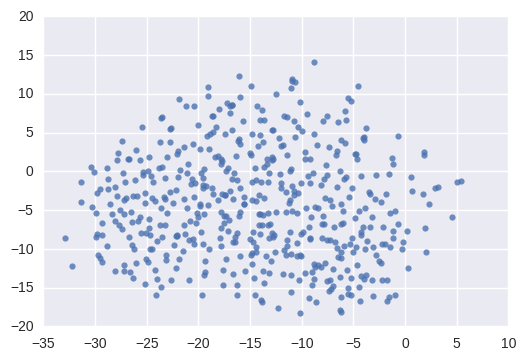

In [51]:
sns.regplot(emb_tsne[:, 0], emb_tsne[:, 1], fit_reg=False)

## NN

In [53]:
x = merge([emb_u, emb_m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = MaxoutDense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = MaxoutDense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1)(x)

In [55]:
model = Model([in_user, in_movie], x, name='model_nn')
model.compile(Adam(0.001), loss='mse')

In [56]:
model.fit([train.userId.values, train.movieId.values], train.rating.values, batch_size=batch_size, nb_epoch=1,
          validation_data=([valid.userId.values, valid.movieId.values], valid.rating.values))

Train on 80003 samples, validate on 20001 samples
Epoch 1/1
80003/80003 [==============================] - 32s - loss: 2.1586 - val_loss: 0.9805


In [57]:
K.set_value(model.optimizer.lr, 0.001)

In [58]:
model.fit([train.userId.values, train.movieId.values], train.rating.values,
          batch_size=batch_size, nb_epoch=5,
          validation_data=([valid.userId.values, valid.movieId.values], valid.rating.values))

Train on 80003 samples, validate on 20001 samples
Epoch 1/5
80003/80003 [==============================] - 30s - loss: 1.1060 - val_loss: 0.9188
Epoch 2/5
80003/80003 [==============================] - 30s - loss: 0.9647 - val_loss: 0.8983
Epoch 3/5
80003/80003 [==============================] - 31s - loss: 0.8972 - val_loss: 0.8609
Epoch 4/5
80003/80003 [==============================] - 31s - loss: 0.8386 - val_loss: 0.8465
Epoch 5/5
80003/80003 [==============================] - 31s - loss: 0.7992 - val_loss: 0.8461
